In [2]:
# 0. get packages

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import requests
import numpy as np
from pathlib import Path
from typing import Sequence

%reload_ext autoreload
%autoreload 2
import pyfiles.build_vp as build_vp
import pyfiles.fig_setup as fig_setup

# Plotting `Variation patterns` for relevant years

I run `build_vp` for the last five years + 2013, aggregate to monthly values, and plot to assess the variation between years in the input data.

In [3]:
# 1. pick years
timeframes = [
    {'start': '2025-01-01T00:00', 'end': '2026-01-01T00:00'},
    {'start': '2024-01-01T00:00', 'end': '2025-01-01T00:00'},
    {'start': '2023-01-01T00:00', 'end': '2024-01-01T00:00'},
    {'start': '2022-01-01T00:00', 'end': '2023-01-01T00:00'},
    {'start': '2021-01-01T00:00', 'end': '2022-01-01T00:00'},
    {'start': '2020-01-01T00:00', 'end': '2021-01-01T00:00'},
    {'start': '2019-01-01T00:00', 'end': '2020-01-01T00:00'},
    {'start': '2018-01-01T00:00', 'end': '2019-01-01T00:00'},
    {'start': '2017-01-01T00:00', 'end': '2018-01-01T00:00'},
    {'start': '2016-01-01T00:00', 'end': '2017-01-01T00:00'},
    {'start': '2015-01-01T00:00', 'end': '2016-01-01T00:00'},
    {'start': '2014-01-01T00:00', 'end': '2015-01-01T00:00'},
    {'start': '2013-01-01T00:00', 'end': '2014-01-01T00:00'},
    {'start': '2012-01-01T00:00', 'end': '2013-01-01T00:00'},
    {'start': '2023-01-01T00:00', 'end': '2026-01-01T00:00'}, # multi year
]

In [4]:
# 2. get all through loop
# 2.1 initiate
dfs = []  # don't call this df; it's a list

for tf in timeframes:
    start, end = tf["start"], tf["end"]
    years, single_year, year_label = build_vp.time_inputs(start=start, end=end)

    # 2. quantities
    df1, s_DK1, s_DK2 = build_vp.build_variation_pattern(
        value_columns=["GrossConsumptionMWh"],
        weights=True,
        name="Electricity_Demand",
        save=False,
        start=start, end=end,
        single_year=single_year,
        year_label=year_label,
    )

    df2 = build_vp.build_variation_pattern(
        value_columns=["SolarPowerLt10kW_MWh", "SolarPowerGe10Lt40kW_MWh", "SolarPowerGe40kW_MWh"],
        name="solar_prod",
        save=False,
        start=start, end=end,
        single_year=single_year,
        year_label=year_label,
    )

    df3 = build_vp.build_variation_pattern(
        value_columns=["OffshoreWindLt100MW_MWh", "OffshoreWindGe100MW_MWh"],
        name="offshore_prod",
        save=False,
        start=start, end=end,
        single_year=single_year,
        year_label=year_label,
    )

    df4 = build_vp.build_variation_pattern(
        value_columns=["OnshoreWindLt50kW_MWh", "OnshoreWindGe50kW_MWh"],
        name="onshore_prod",
        save=False,
        start=start, end=end,
        single_year=single_year,
        year_label=year_label,
    )

    # 3. prices
    # 0. get using API
    BASE = "https://api.energidataservice.dk/dataset/Elspotprices"
    params = {
        "start":    start,             
        "end":      end,
        "timezone": "UTC",                       
        "filter":   '{"PriceArea":["DK1","DK2"]}',              # Q til FL
        "columns":  "HourUTC,HourDK,PriceArea,SpotPriceEUR",
        "sort":     "HourUTC asc",
        "limit":    0                                    
    }
    r = requests.get(BASE, params=params, timeout=60)
    r.raise_for_status()
    df = pd.DataFrame(r.json().get("records", []))
    df["HourUTC"] = pd.to_datetime(df["HourUTC"])
    df = df[~((df["HourUTC"].dt.month == 2) & (df["HourUTC"].dt.day == 29))]
    w_map = {"DK1": s_DK1, "DK2": s_DK2} # from electricity demand
    df["w"] = df["PriceArea"].map(w_map).astype(float)
    g = df.assign(pxw=df["SpotPriceEUR"] * df["w"]).groupby("HourUTC", sort=True)
    df_avg = (g["pxw"].sum() / g["w"].sum())
    if not single_year:
        template = pd.date_range("2021-01-01 00:00", periods=8760, freq="H")
        df_avg = (
            df_avg.groupby(df_avg.index.strftime("%m-%d %H"))
            .mean()
            .reindex(template.strftime("%m-%d %H"))
        )
    df5 = pd.concat([df_avg, df_avg.iloc[:24]], ignore_index=True)

    # 4. collect all
    dfs.append({"year": year_label, "demand": df1, "solar": df2, "offshore": df3, "onshore": df4, "prices": df5})

C:\Users\LinusLindquist\AppData\Local\Temp\ipykernel_21192\93376551.py:69: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  template = pd.date_range("2021-01-01 00:00", periods=8760, freq="H")


In [5]:
# 3. collect
wide_rows = []
for d in dfs:
    y = d["year"]

    # one row per original index, vars become columns
    tmp = pd.concat(
        {
            "demand": d["demand"],
            "solar": d["solar"],
            "offshore": d["offshore"],
            "onshore": d["onshore"],
            "prices": d["prices"],
        },
        axis=1,
    )

    tmp = tmp.reset_index().rename(columns={"index": "index"})  # keep original index as a column
    tmp["year"] = y

    wide_rows.append(tmp)

panel_wide = pd.concat(wide_rows, ignore_index=True)

In [ ]:
# 4. aggregate to months

# 4.1 find months
df = panel_wide.copy()
base = pd.Timestamp("2024-01-01 00:00")
df["dt"] = base + pd.to_timedelta(df["index"], unit="h")
df["month"] = df["dt"].dt.to_period("M")

# 4.2 compute
monthly = (
    df.groupby(["year", "month"], as_index=False)
      .agg(
          demand_MWh=("demand", "sum"),
          solar_MWh=("solar", "sum"),
          offshore_MWh=("offshore", "sum"),
          onshore_MWh=("onshore", "sum"),
          price_mean=("prices", "mean"),
      )
)

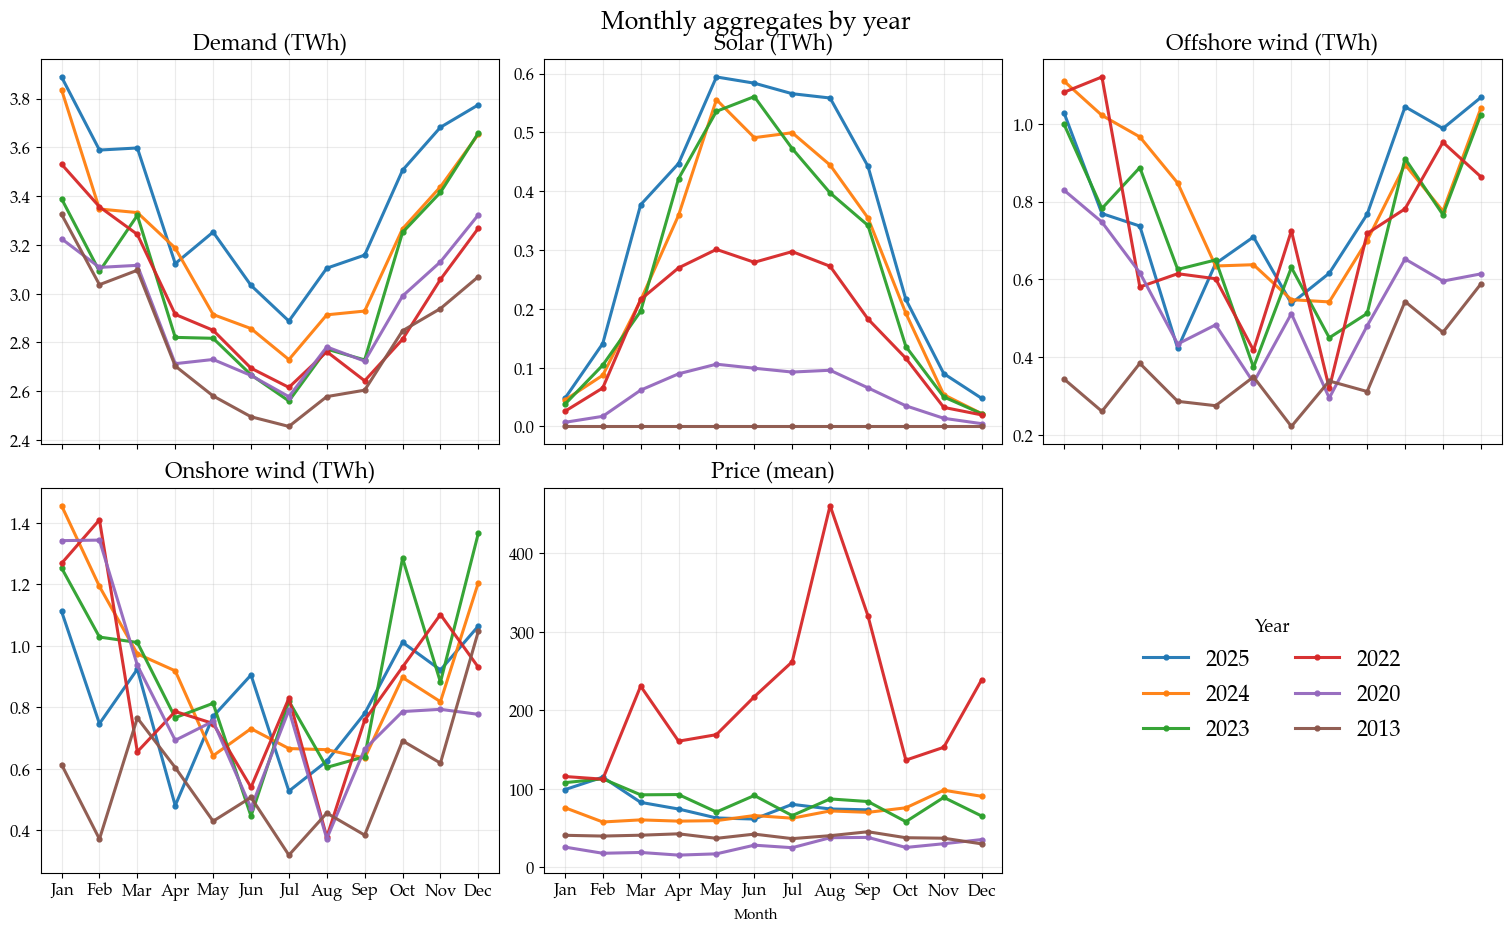

In [ ]:
# # 5. plot simple
# m = monthly.copy()
# m["month"] = pd.PeriodIndex(m["month"], freq="M")
# m["m"] = m["month"].dt.month

# # What to plot + how to label/scale it
# specs = [
#     ("demand_MWh",   1e6, "Demand (TWh)"),
#     ("solar_MWh",    1e6, "Solar (TWh)"),
#     ("offshore_MWh", 1e6, "Offshore wind (TWh)"),
#     ("onshore_MWh",  1e6, "Onshore wind (TWh)"),
#     ("price_mean",   1.0, "Price (mean)"),
# ]

# month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# fig, axes = plt.subplots(2, 3, figsize=(15, 9), sharex=True, constrained_layout=True)
# axes = axes.ravel()

# # years = sorted(m["year"].unique())
# years = ['2025','2024','2023','2022','2020','2013']

# for i, (col, scale, ylab) in enumerate(specs):
#     ax = axes[i]

#     for year in years:
#         g = m.loc[m["year"] == year].sort_values("m")
#         ax.plot(
#             g["m"],
#             g[col] / scale,
#             linewidth=2.2,
#             marker="o",
#             markersize=3.5,
#             alpha=0.95,
#             label=str(year),
#         )

#     ax.set_title(ylab, pad=8)
#     ax.grid(True, which="major", alpha=0.25)

# # Empty panel = legend panel
# leg_ax = axes[len(specs)]
# leg_ax.axis("off")
# handles, labels = axes[0].get_legend_handles_labels()
# leg_ax.legend(
#     handles, labels,
#     title="Year",
#     loc="center",
#     frameon=False,
#     ncol=2,
# )

# # X axis formatting
# for ax in axes[:len(specs)]:
#     ax.set_xticks(range(1, 13))
#     ax.set_xticklabels(month_labels)

# fig.suptitle("Monthly aggregates by year", y=1.02)
# fig.supxlabel("Month")

# plt.show()

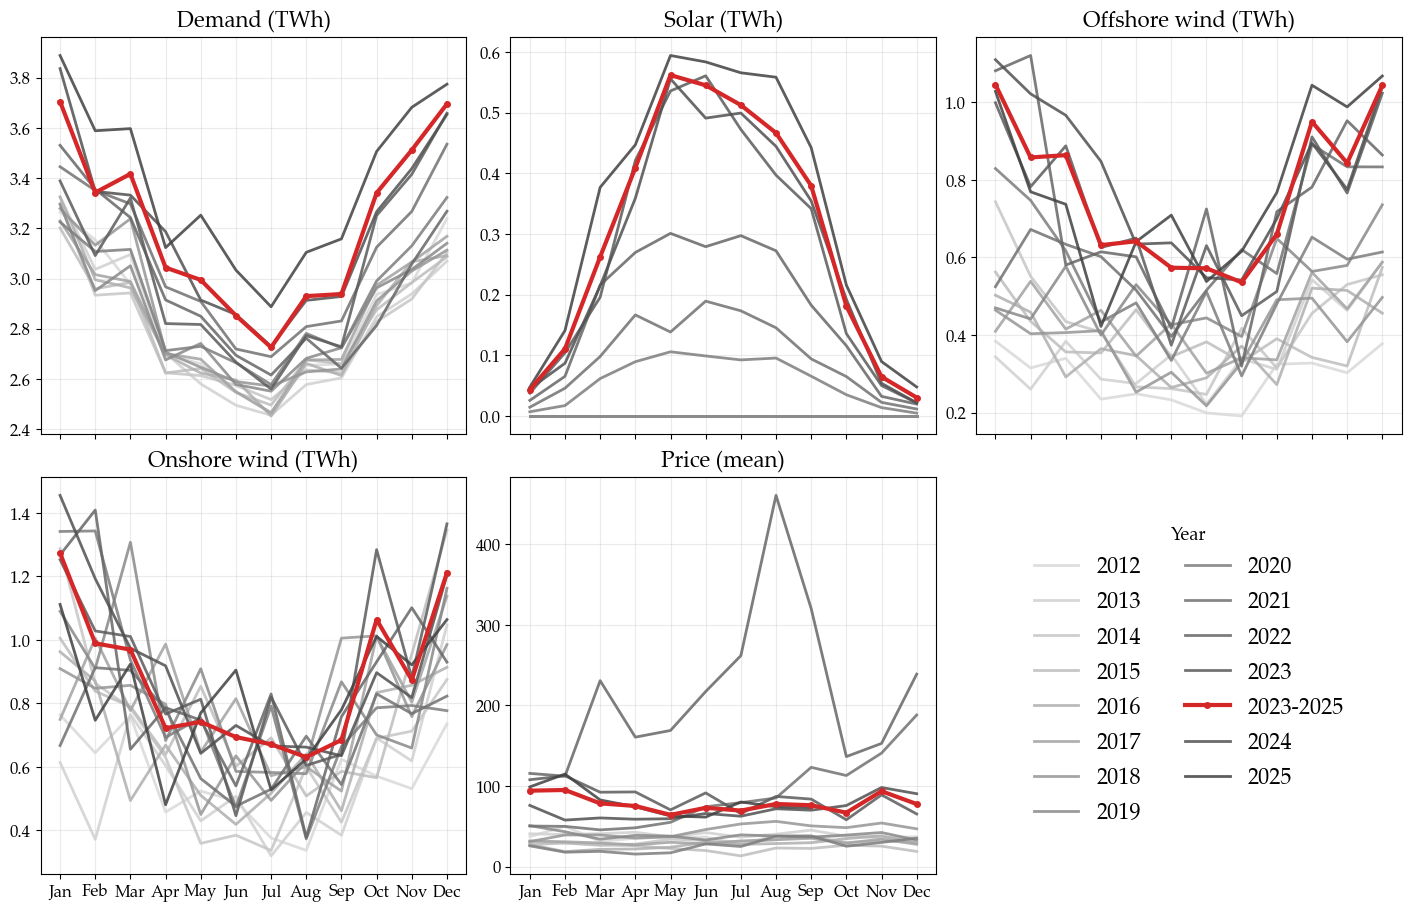

In [8]:
# 6. plot grays
m = monthly.copy()
m["month"] = pd.PeriodIndex(m["month"], freq="M")
m["m"] = m["month"].dt.month

specs = [
    ("demand_MWh",   1e6, "Demand (TWh)"),
    ("solar_MWh",    1e6, "Solar (TWh)"),
    ("offshore_MWh", 1e6, "Offshore wind (TWh)"),
    ("onshore_MWh",  1e6, "Onshore wind (TWh)"),
    ("price_mean",   1.0, "Price (mean)"),
]

month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

years = sorted(m["year"].astype(str).unique())
multi_years = [y for y in years if "-" in y]
single_years = [y for y in years if "-" not in y]

# grayscale palette for single-year lines
cmap = plt.get_cmap("Greys")
# avoid pure white and pure black; pick mid-range grays
grays = [cmap(x) for x in np.linspace(0.25, 0.80, max(len(single_years), 1))]

color_map = {y: grays[i] for i, y in enumerate(single_years)}
for y in multi_years:
    color_map[y] = "tab:red"  # highlight

fig, axes = plt.subplots(2, 3, figsize=(14, 9), sharex=True, constrained_layout=True)
axes = axes.ravel()

for i, (col, scale, ylab) in enumerate(specs):
    ax = axes[i]

    for y in years:
        g = m.loc[m["year"].astype(str) == y].sort_values("m")

        is_multi = "-" in y
        ax.plot(
            g["m"],
            g[col] / scale,
            color=color_map[y],
            linewidth=3.0 if is_multi else 2.0,
            alpha=1.0 if is_multi else 0.85,
            marker="o" if is_multi else None,
            markersize=4.0 if is_multi else 0,
            label=y,
            zorder=3 if is_multi else 2,
        )

    ax.set_title(ylab, pad=8)
    ax.grid(True, which="major", alpha=0.25)

# legend in the empty (6th) panel
leg_ax = axes[len(specs)]
leg_ax.axis("off")
handles, labels = axes[0].get_legend_handles_labels()
leg_ax.legend(handles, labels, title="Year", loc="center", frameon=False, ncol=2)

# x-axis formatting
for ax in axes[:len(specs)]:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_labels)

# fig.suptitle("Figure 1: Empirical variation patterns for EnergyPLAN indput", y=-0.02)

plt.show()

In [9]:
fig.savefig("0_figs/fig0.pdf", dpi=300)

*Cost numbers*

In [10]:
# O&M in EUR
print(f'{35*0.86:.2f} EUR/MWh')
print(f'{5000*0.86:.2f} EUR/MWh')
print(f'{30.1*1000*.85*8760/(4300*1e6) *100:.2f} pct. of inv.')

30.10 EUR/MWh
4300.00 EUR/MWh
5.21 pct. of inv.
